## Step 5: Learning Curve & Pareto Analysis of Worker Performance

## Project Context
This notebook extends the SLA compliance analysis by focusing on **worker learning behaviour** and **contribution imbalance**.

Specifically, we aim to:
- Measure how long workers take to meet SLA **for the first time**
- Analyse productivity improvement over time (learning curves)
- Identify high-impact workers using Pareto (80/20) analysis

This analysis helps answer:
- How quickly do workers become SLA-compliant?
- Which workers improve fastest?
- Do a small number of workers deliver most of the output?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Load synthetic dataset
df = pd.read_csv("simulated_worker_tasks.csv", parse_dates=["task_date"])

df["task_date"] = pd.to_datetime(df["task_date"])
df.sort_values(by=["worker_id", "task_date"], inplace=True)

df.head()

,task_id,worker_id,task_date,task_complexity,time_taken_minutes,accuracy
0,77016b53-3aa3-497a-b042-4246e5a9583e,W_001,2024-01-01,Low,5.28,0.990
1,7f65a185-9675-4d6d-974c-c0b27805270a,W_001,2024-01-01,Medium,7.30,0.946
2,a78aa64d-4a37-4105-baab-125b5d293c4e,W_001,2024-01-01,Low,4.43,0.952
3,2d08d6c7-c351-40f4-af67-5a62f3a250ce,W_001,2024-01-01,Medium,5.41,0.913
4,c236a814-63f0-4035-8e30-b4642282a1d8,W_001,2024-01-01,Medium,7.36,0.908


## SLA Definitions (Client-Fixed)

These thresholds are assumed to be externally defined by the client.
They are **not derived from historical performance**.

In [2]:
ACCURACY_SLA = 0.95      # 95% minimum accuracy
TASK_COUNT_SLA = 20        # Minimum tasks per worker per day

## Aggregate to Worker-Day Level

Since the dataset is task-level, we aggregate metrics at a daily granularity.

In [3]:
daily_metrics = (
    df.groupby(["worker_id", "task_date"])
    .agg(
        avg_accuracy=("accuracy", "mean"),
        tasks_completed=("task_id", "count")
    )
    .reset_index()
)

daily_metrics.head()

,worker_id,task_date,avg_accuracy,tasks_completed
0,W_001,2024-01-01,0.955167,18
1,W_001,2024-01-02,0.941176,17
2,W_001,2024-01-03,0.932769,13
3,W_001,2024-01-04,0.945667,12
4,W_001,2024-01-05,0.934905,21


## Daily SLA Compliance Evaluation

In [4]:
daily_metrics["accuracy_sla_met"] = (
    daily_metrics["avg_accuracy"] >= ACCURACY_SLA
)

daily_metrics["task_count_sla_met"] = (
    daily_metrics["tasks_completed"] >= TASK_COUNT_SLA
)

daily_metrics["daily_overall_sla_met"] = (
    daily_metrics["accuracy_sla_met"] &
    daily_metrics["task_count_sla_met"]
)

daily_metrics.head()

,worker_id,task_date,avg_accuracy,tasks_completed,accuracy_sla_met,task_count_sla_met,daily_overall_sla_met
0,W_001,2024-01-01,0.955167,18,True,False,False
1,W_001,2024-01-02,0.941176,17,False,False,False
2,W_001,2024-01-03,0.932769,13,False,False,False
3,W_001,2024-01-04,0.945667,12,False,False,False
4,W_001,2024-01-05,0.934905,21,False,True,False


## Learning Curve Analysis (Accuracy Over Time)

We compute cumulative average accuracy to observe worker learning behaviour.

In [5]:
daily_metrics = daily_metrics.sort_values(["worker_id", "task_date"])

daily_metrics["cumulative_avg_accuracy"] = (
    daily_metrics.groupby("worker_id")["avg_accuracy"]
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
)

daily_metrics.head()

,worker_id,task_date,avg_accuracy,tasks_completed,accuracy_sla_met,task_count_sla_met,daily_overall_sla_met,cumulative_avg_accuracy
0,W_001,2024-01-01,0.955167,18,True,False,False,0.955167
1,W_001,2024-01-02,0.941176,17,False,False,False,0.948172
2,W_001,2024-01-03,0.932769,13,False,False,False,0.943037
3,W_001,2024-01-04,0.945667,12,False,False,False,0.943695
4,W_001,2024-01-05,0.934905,21,False,True,False,0.941937


### Sample Learning Curves

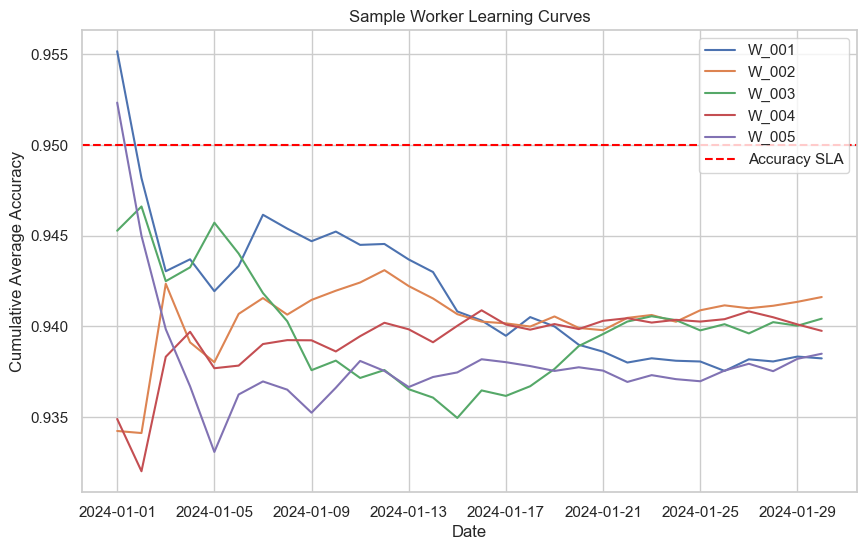

In [6]:
sample_workers = daily_metrics["worker_id"].unique()[:5]

for worker in sample_workers:
    worker_data = daily_metrics[daily_metrics["worker_id"] == worker]
    plt.plot(worker_data["task_date"], worker_data["cumulative_avg_accuracy"], label=worker)

plt.axhline(ACCURACY_SLA, linestyle="--", color="red", label="Accuracy SLA")
plt.legend()
plt.title("Sample Worker Learning Curves")
plt.ylabel("Cumulative Average Accuracy")
plt.xlabel("Date")
plt.show()

## Time to First Task SLA Achievement

Time to SLA is defined as the number of days from a worker’s first task
until they meet **Task Count SLAs**.

In [7]:
# Identify the first task date (onboarding start) for each worker
worker_start_dates = (
    df.groupby("worker_id")["task_date"]
    .min()
    .reset_index(name="start_date")
)

# Identify the first date where both SLAs are met
worker_first_sla_dates = (
    daily_metrics[daily_metrics["task_count_sla_met"]]
    .groupby("worker_id")["task_date"]
    .min()
    .reset_index(name="first_sla_date")
)

# Merge start date and SLA achievement date
throughput_time_to_sla = worker_start_dates.merge(
    worker_first_sla_dates,
    on="worker_id",
    how="left"
)

# Calculate time taken (in days)
throughput_time_to_sla["days_to_first_sla"] = (
    throughput_time_to_sla["first_sla_date"] - throughput_time_to_sla["start_date"]
).dt.days + 1

throughput_time_to_sla.head()

,worker_id,start_date,first_sla_date,days_to_first_sla
0,W_001,2024-01-01,2024-01-05,5.0
1,W_002,2024-01-01,2024-01-01,1.0
2,W_003,2024-01-01,2024-01-19,19.0
3,W_004,2024-01-01,2024-01-18,18.0
4,W_005,2024-01-01,NaT,NaN


### Distribution of Time to Task SLA

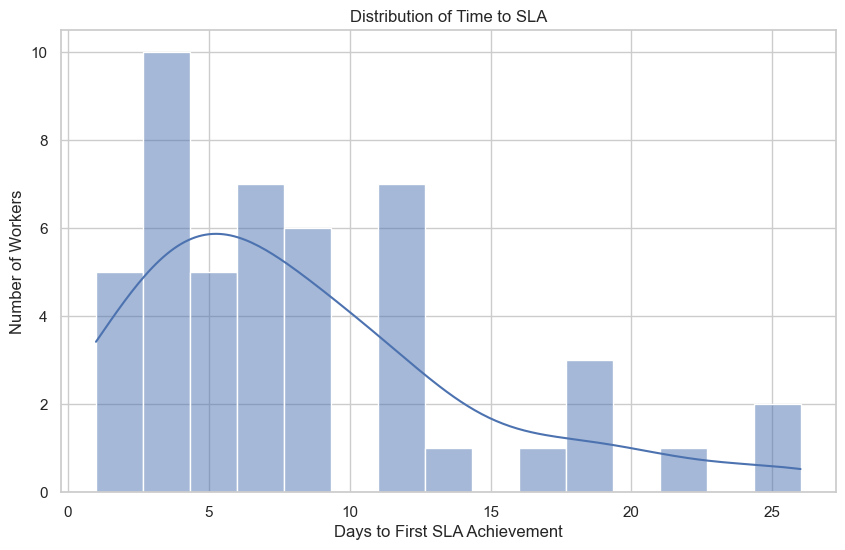

In [8]:
sns.histplot(throughput_time_to_sla["days_to_first_sla"].dropna(), bins=15, kde=True)
plt.xlabel("Days to First SLA Achievement")
plt.ylabel("Number of Workers")
plt.title("Distribution of Time to SLA")
plt.show()

## Time to First Accuracy SLA Achievement

Time to SLA is defined as the number of days from a worker’s first task
until they meet **Task Accuracy SLAs**.

In [9]:
# Identify the first task date (onboarding start) for each worker
worker_start_dates = (
    df.groupby("worker_id")["task_date"]
    .min()
    .reset_index(name="start_date")
)

# Identify the first date where both SLAs are met
worker_first_sla_dates = (
    daily_metrics[daily_metrics["accuracy_sla_met"]]
    .groupby("worker_id")["task_date"]
    .min()
    .reset_index(name="first_sla_date")
)

# Merge start date and SLA achievement date
accuracy_time_to_sla = worker_start_dates.merge(
    worker_first_sla_dates,
    on="worker_id",
    how="left"
)

# Calculate time taken (in days)
accuracy_time_to_sla["days_to_first_sla"] = (
    accuracy_time_to_sla["first_sla_date"] - accuracy_time_to_sla["start_date"]
).dt.days + 1

accuracy_time_to_sla.head()

,worker_id,start_date,first_sla_date,days_to_first_sla
0,W_001,2024-01-01,2024-01-01,1
1,W_002,2024-01-01,2024-01-03,3
2,W_003,2024-01-01,2024-01-05,5
3,W_004,2024-01-01,2024-01-03,3
4,W_005,2024-01-01,2024-01-01,1


### Distribution of Time to Accuracy SLA

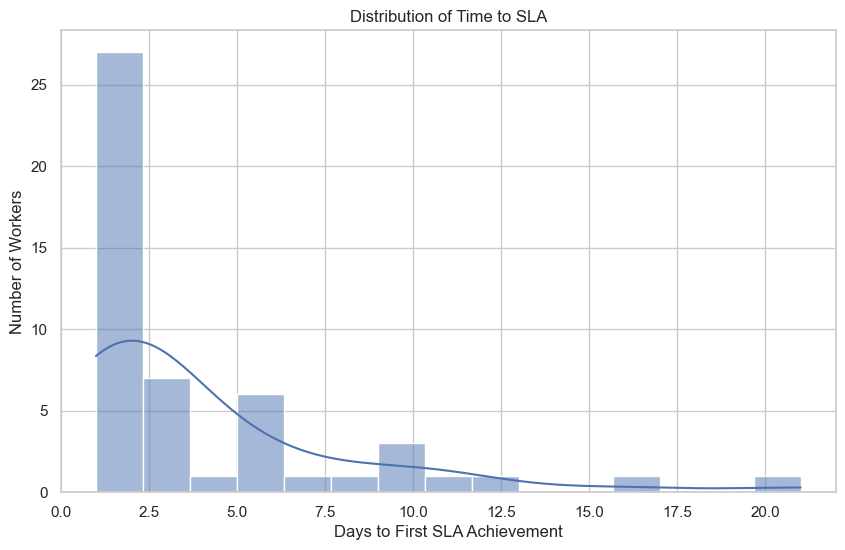

In [11]:
sns.histplot(accuracy_time_to_sla["days_to_first_sla"].dropna(), bins=15, kde=True)
plt.xlabel("Days to First SLA Achievement")
plt.ylabel("Number of Workers")
plt.title("Distribution of Time to SLA")
plt.show()

## Comparison: Accuracy vs Throughput Readiness

In [13]:
# Merge both SLA timelines
sla_comparison = (
    accuracy_time_to_sla[["worker_id", "days_to_first_sla"]]
    .merge(
        throughput_time_to_sla[["worker_id", "days_to_first_sla"]],
        on="worker_id",
        how="outer"
    )
)

sla_comparison.head()

,worker_id,days_to_first_sla_x,days_to_first_sla_y
0,W_001,1,5.0
1,W_002,3,1.0
2,W_003,5,19.0
3,W_004,3,18.0
4,W_005,1,NaN


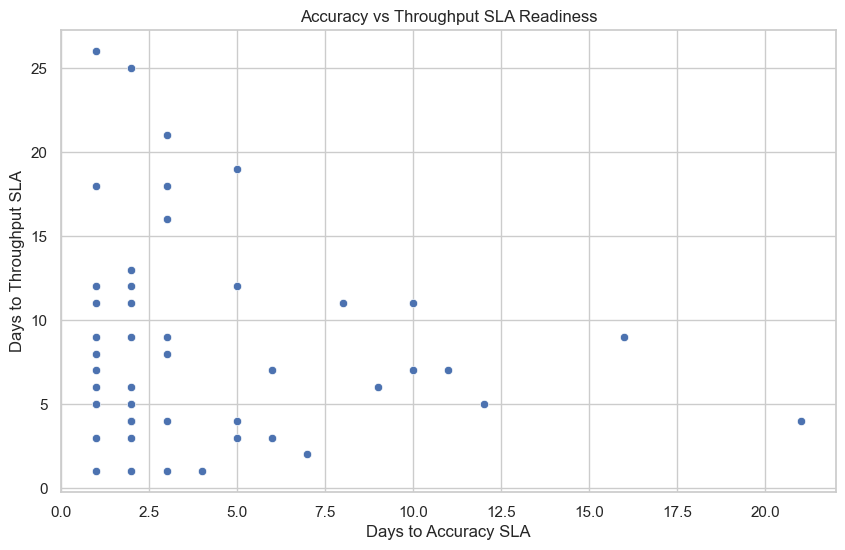

In [14]:
sns.scatterplot(
    data=sla_comparison,
    x="days_to_first_sla_x",
    y="days_to_first_sla_y"
)
plt.xlabel("Days to Accuracy SLA")
plt.ylabel("Days to Throughput SLA")
plt.title("Accuracy vs Throughput SLA Readiness")
plt.show()

## Pareto Analysis (80/20 Rule)

We assess whether a small proportion of workers complete most of the tasks.

In [15]:
worker_output = (
    df.groupby("worker_id")["task_id"]
    .count()
    .sort_values(ascending=False)
    .reset_index(name="total_tasks")
)

worker_output["cumulative_pct"] = (
    worker_output["total_tasks"].cumsum() /
    worker_output["total_tasks"].sum()
)

worker_output.head()

,worker_id,total_tasks,cumulative_pct
0,W_045,488,0.021934
1,W_047,474,0.043238
2,W_024,473,0.064497
3,W_046,468,0.085532
4,W_002,467,0.106522


### Pareto Curve

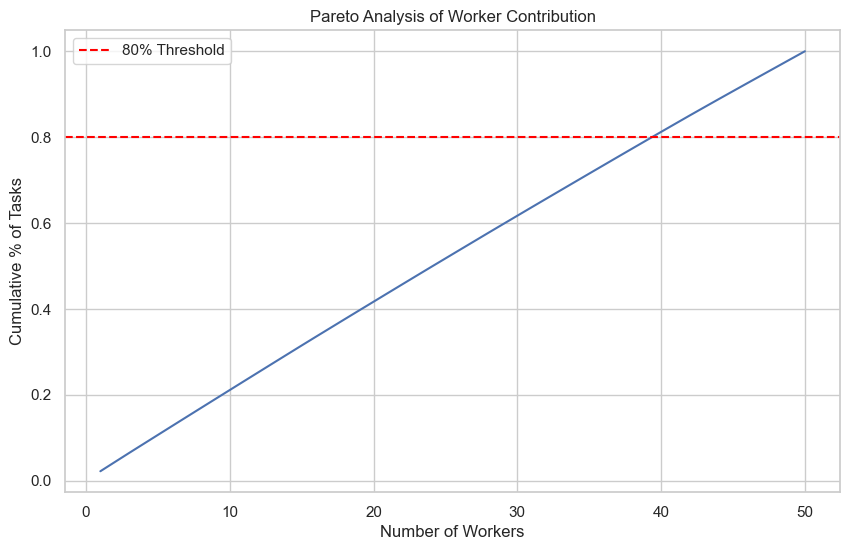

In [16]:
plt.plot(worker_output.index + 1, worker_output["cumulative_pct"])
plt.axhline(0.8, linestyle="--", color="red", label="80% Threshold")
plt.xlabel("Number of Workers")
plt.ylabel("Cumulative % of Tasks")
plt.title("Pareto Analysis of Worker Contribution")
plt.legend()
plt.show()

## SLA Failure Mode Analysis

We classify worker-days based on which SLA was violated.

In [17]:
daily_metrics["sla_failure_type"] = np.select(
    [
        ~daily_metrics["accuracy_sla_met"] & daily_metrics["task_count_sla_met"],
        daily_metrics["accuracy_sla_met"] & ~daily_metrics["task_count_sla_met"],
        ~daily_metrics["accuracy_sla_met"] & ~daily_metrics["task_count_sla_met"]
    ],
    [
        "Accuracy Only",
        "Throughput Only",
        "Accuracy & Throughput"
    ],
    default="Met All"
)

daily_metrics["sla_failure_type"].value_counts()

sla_failure_type
Accuracy & Throughput    1029
Throughput Only           295
Accuracy Only             158
Met All                    18
Name: count, dtype: int64

## Key Insights

- Workers exhibit different learning speeds and SLA readiness timelines
- Accuracy generally improves before throughput stabilises
- A small subset of workers delivers a disproportionate share of output
- SLA breaches often stem from throughput rather than quality alone
- Time-to-SLA is a powerful metric for onboarding and incentive design

- Accuracy SLA is generally achieved **earlier** than throughput SLA
- Some workers are accurate but slow (capacity constrained)
- Some workers are fast but inaccurate (quality constrained)
- Treating SLA as a single metric hides these dynamics
- Separate SLA timelines enable **targeted training and incentives**
